In [34]:
import numpy as np
import keras
import cv2 as cv2
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import matplotlib.patches as mpatches
from skimage.morphology import label
from skimage import *
%matplotlib inline

In [35]:
train_path = 'Training'
test_path = 'Test'
valid_path = 'Valid'

In [36]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),classes=['Healthy_Leaves','Unhealthy_Leaves'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),classes=['Healthy_Leaves','Unhealthy_Leaves'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224),classes=['Healthy_Leaves','Unhealthy_Leaves'], batch_size=5)

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [37]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

# Confusion matrix

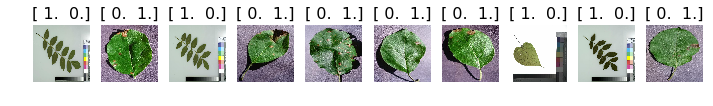

In [38]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [39]:
#rounded_predictions = model.predict_classes(scaled_test_samples, batch_size=10,verbose=0)

In [40]:
#cm = confusion_matrix(test_labels, rounded_predictions)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Prepoccessing the images

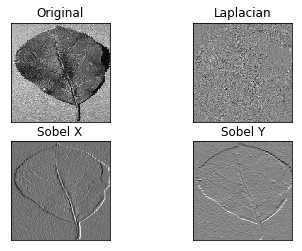

In [42]:
image_path = 'Training/Unhealthy_Leaves/d2313a95-61dd-45de-a8b8-3c2992e2b97f___JR_FrgE.S 8652.JPG'
nimg = cv2.imread(image_path,0)
edges = cv2.Canny(nimg,200,200)

laplacian = cv2.Laplacian(nimg,cv2.CV_64F)
sobelx = cv2.Sobel(nimg,cv2.CV_64F,1,0,ksize=5)  # x
sobely = cv2.Sobel(nimg,cv2.CV_64F,0,1,ksize=5)  # y


plt.subplot(121),plt.imshow(nimg,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,1),plt.imshow(nimg,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

In [43]:
image_path = 'Training/Healthy_Leaves/wb1226-06-4.jpg'
img = cv2.imread(image_path, 1)#color
cv2.imshow('colored image', img)
cv2.waitKey()
nimg = cv2.imread(image_path, 0)#grayscale
nimg = cv2.threshold(nimg, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
image, contours, hier = cv2.findContours(nimg, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
ret, labels = cv2.connectedComponents(nimg)

# Map component labels to hue val
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
# set bg label to black
labeled_img[label_hue==0] = 0

cv2.imshow('labeled.png', labeled_img)
cv2.waitKey()
cv2.destroyAllWindows()

In [44]:
# label_image = label(labeled_img)
# blobs = measure.label(label_image, connectivity=1)
# props = measure.regionprops(blobs)
# props[0].bbox
#roi = regionprops(props)
#props[0].area
#cv2.imshow(roi)
w_max = 0
h_max = 0
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(nimg, (x,y), (x+w, y+h), (0,255,0),2)
    #print(x,y,w,h)
    if (w_max*h_max) < (w*h) and x != 0 and y != 0:
        x_max = x
        y_max = y
        w_max = w
        h_max = h
#print(x_max,y_max,h_max,w_max)
cv2.rectangle(nimg, (x_max,y_max), (x_max+w_max, y_max+h_max), (0,255,0),2)
cv2.imshow('uncropped image', nimg)
cv2.waitKey()
img = img[y_max:y_max+h_max, x_max:x_max+w_max]
cv2.imshow('cropped image', img)
cv2.waitKey()
cv2.destroyAllWindows()

# Training the model

In [45]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    Flatten(),
    Dense(2,activation='softmax')
])

In [46]:
model.compile(Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [47]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4,epochs=10,verbose=2)

Epoch 1/10
 - 2s - loss: 7.3213 - acc: 0.5250 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 2/10
 - 2s - loss: 8.8650 - acc: 0.4500 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 3/10
 - 1s - loss: 8.8650 - acc: 0.4500 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 4/10
 - 1s - loss: 8.4620 - acc: 0.4750 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 5/10
 - 1s - loss: 6.8502 - acc: 0.5750 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 6/10
 - 1s - loss: 7.2531 - acc: 0.5500 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 7/10
 - 1s - loss: 7.2531 - acc: 0.5500 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 8/10
 - 1s - loss: 9.2679 - acc: 0.4250 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 9/10
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 10/10
 - 1s - loss: 8.4620 - acc: 0.4750 - val_loss: 5.6413 - val_acc: 0.6500


# Predict

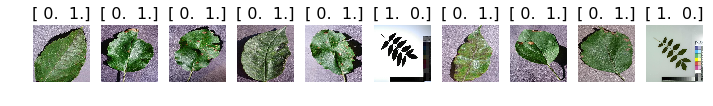

In [48]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [49]:
test_labels = test_labels[:,0]
test_labels

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.], dtype=float32)

In [50]:
predictions = model.predict_generator(test_batches,steps=1,verbose=0)

In [51]:
predictions

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

In [52]:
cm = confusion_matrix(test_labels, predictions[:,0])

Confusion matrix, without normalization
[[0 8]
 [0 2]]


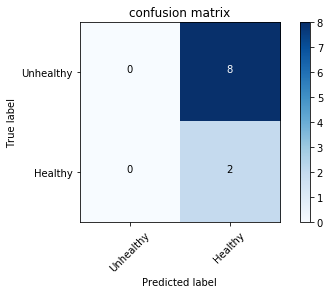

In [53]:
cm_plot_labels = ['Unhealthy', 'Healthy']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')

# Fine tuninig model

In [54]:
vgg16_model = keras.applications.vgg16.VGG16()

In [55]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [56]:
type(vgg16_model)

keras.engine.training.Model

In [57]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [59]:
model.layers.pop()

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [61]:
for layer in model.layers:
    layer.trainable = False

In [62]:
model.add(Dense(2, activation='softmax'))

In [63]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [64]:
model.compile(Adam(lr=.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [65]:
model.fit_generator(train_batches, steps_per_epoch=4,
                   validation_data=valid_batches, validation_steps=4,epochs=5,verbose=2)

Epoch 1/10
 - 16s - loss: 0.6941 - acc: 0.4250 - val_loss: 0.6981 - val_acc: 0.4000
Epoch 2/10
 - 15s - loss: 0.6775 - acc: 0.9000 - val_loss: 0.6883 - val_acc: 0.6000
Epoch 3/10
 - 14s - loss: 0.6652 - acc: 1.0000 - val_loss: 0.6807 - val_acc: 0.9500
Epoch 4/10
 - 14s - loss: 0.6567 - acc: 1.0000 - val_loss: 0.6728 - val_acc: 1.0000
Epoch 5/10
 - 14s - loss: 0.6497 - acc: 1.0000 - val_loss: 0.6639 - val_acc: 1.0000
Epoch 6/10
 - 14s - loss: 0.6432 - acc: 1.0000 - val_loss: 0.6558 - val_acc: 1.0000
Epoch 7/10
 - 14s - loss: 0.6380 - acc: 1.0000 - val_loss: 0.6491 - val_acc: 1.0000
Epoch 8/10
 - 14s - loss: 0.6359 - acc: 1.0000 - val_loss: 0.6437 - val_acc: 1.0000
Epoch 9/10
 - 15s - loss: 0.6343 - acc: 1.0000 - val_loss: 0.6390 - val_acc: 1.0000
Epoch 10/10
 - 15s - loss: 0.6311 - acc: 1.0000 - val_loss: 0.6355 - val_acc: 1.0000


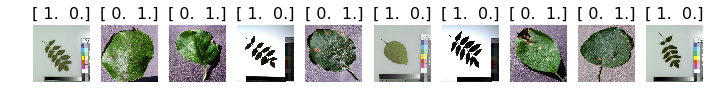

In [68]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [69]:
test_labels = test_labels[:,0]
test_labels

array([ 1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.], dtype=float32)

In [70]:
predictions = model.predict_generator(test_batches,steps=1,verbose=0)
predictions

array([[ 0.52976686,  0.4702332 ],
       [ 0.46601549,  0.53398454],
       [ 0.53003329,  0.46996674],
       [ 0.46609426,  0.53390568],
       [ 0.46603292,  0.53396708],
       [ 0.4660359 ,  0.53396404],
       [ 0.4660244 ,  0.5339756 ],
       [ 0.52944779,  0.47055221],
       [ 0.52977657,  0.47022349],
       [ 0.46602762,  0.53397238]], dtype=float32)

Confusion matrix, without normalization
[[2 3]
 [4 1]]


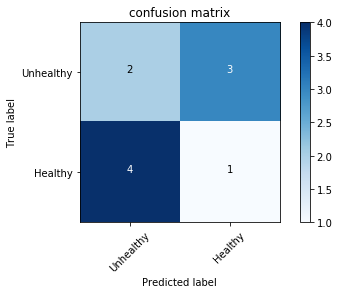

In [72]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
cm_plot_labels = ['Unhealthy', 'Healthy']
plot_confusion_matrix(cm, cm_plot_labels, title='confusion matrix')